# Note: This notebook requires to have Flickr8k (and Flickr30k for the latest cells) as a zipped file titled flickr8k.zip in the same folder as this notebook in order to run. We save the outputs of each cell instead because we could not upload Flickr8k or Flickr30k due to the file size limit (500 MB).

# INSTALLS AND IMPORTS

In [ ]:
!pip install efficientnet_pytorch
!pip install spacy
from efficientnet_pytorch import EfficientNet

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=466ba5ad4b3f3b5b0850623458118ca336c1ee3be2614025f2f6351daacff2b9
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
!pip install bcolz
import bcolz

     |████████████████████████████████| 1.5 MB 4.7 MB/s 
  Created wheel for bcolz: filename=bcolz-1.2.1-cp37-cp37m-linux_x86_64.whl size=2651779 sha256=7b063d648322d9f62940eb5eff6277b309624e59dc399c0eca25ff31d9b7b5ec
  Stored in directory: /root/.cache/pip/wheels/2c/35/ca/9d914de345914e2446ea285170329f771b8abba2a00f7650bd
Successfully built bcolz


In [ ]:
!pip install einops

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
import pickle
from torchvision.io import read_image
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import shutil
import os
import copy
import torchvision.transforms as T
from torchsummary import summary
from torchvision.models import efficientnet_b4,efficientnet_b0
import random
import pandas as pd
import json
from efficientnet_pytorch import EfficientNet
import spacy
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from spacy.attrs import ORTH
import cv2 as cv 
from google.colab.patches import cv2_imshow # for image display
from einops import rearrange
import math
from math import log
from torchtext.data.metrics import bleu_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# SETUP & FUNCTIONS

## Flickr dataset functions
Create the training set, validation set and test set, and their respective data loaders.

In [ ]:
class FlickrDataset(Dataset):
    
    def __init__(self, root, ann_file, img_transform=None, txt_transform=None):
        df = pd.read_csv(ann_file)
        self.root = root
        self.img_transform = img_transform
        self.txt_transform = txt_transform
        self.img_ids = df['image']
        self.captions = df['caption']
        self.vocab = Vocabulary()
        self.vocab.build_vocab(self.captions.tolist())
    
    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, self.img_ids[idx]))
        img = self.img_transform(img) if self.img_transform is not None else img
        caption = self.captions[idx]
        caption = self.txt_transform(caption) if self.txt_transform is not None else caption
        caption = self.vocab.numericalize('<sos> ' + caption.lstrip() + ' <eos>')
        return img, torch.Tensor(caption)


In [ ]:
class FlickrDatasetVal(Dataset):
    
    def __init__(self, root, ann_file, img_transform=None, txt_transform=None):
        df = pd.read_csv(ann_file)
        self.root = root
        self.img_transform = img_transform
        self.txt_transform = txt_transform
        self.img_ids = df['image']
        self.captions = df['captions']
        self.vocab = Vocabulary()
        self.vocab.build_vocab(self.captions.tolist())
    
    def __len__(self):
        return len(self.img_ids)

    def collate_captions(self, captions):
        lengths = [len(cap) for cap in captions]
        targets = torch.zeros(len(captions), max(lengths)).long()
        for i, cap in enumerate([torch.tensor(caption) for caption in captions]):
            end = lengths[i]
            targets[i, :end] = cap[:end]
        return targets  

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, self.img_ids[idx]))
        img = self.img_transform(img) if self.img_transform is not None else img
        captions = self.captions[idx].split('|')
        captions = ['<sos> ' + caption + ' <eos>' for caption in captions]
        captions = self.txt_transform(captions) if self.txt_transform is not None else captions
        captions = [self.vocab.numericalize(caption) for caption in captions]        
        return img, self.collate_captions(captions)

In [ ]:
def collate_fn(data):
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths


def collate_fn_val(data):
    images, captions = zip(*data)
    images = torch.stack(images, 0)
    max_length = max([len(cap[0]) for cap in captions])
    targets = torch.zeros(len(captions), 5, max_length).long()
    for i, caps in enumerate(captions):
        end = caps.shape[1]
        targets[i, :, :end] = caps[:end]
    return images, targets, max_length


In [ ]:
spacy_eng = spacy.load("en_core_web_sm")
spacy_eng.tokenizer.add_special_case('<sos>', [{ORTH: "<sos>"}])
spacy_eng.tokenizer.add_special_case('<eos>', [{ORTH: "<eos>"}])
spacy_eng.tokenizer.add_special_case('<pad>', [{ORTH: "<pad>"}])
spacy_eng.tokenizer.add_special_case('<unk>', [{ORTH: "<unk>"}])

class Vocabulary:

    def __init__(self):
        self.itos = {0:"<pad>",1:"<sos>",2:"<eos>",3:"<unk>"}
        self.stoi = {v:k for k,v in self.itos.items()}
        
    def __len__(self): return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        idx = 4
        # add words from all sentences to vocab
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                if word not in self.stoi:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self,text):
        tokenized_text = self.tokenize(text)
        return [self.stoi[token] if token in self.stoi else self.stoi["<unk>"] for token in tokenized_text]


## Feature extraction

In [ ]:
#Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'efficientnet-b4'
classifier_model = EfficientNet.from_pretrained(model_name).to(device)
image_size = EfficientNet.get_image_size(model_name)
classifier_model.eval()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b4


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

## Image preprocessing

In [ ]:
#Image preprocessing, adapted to Daniel's loader

def preprocessing_with_aug():
  transf_aug = T.Compose([T.RandomChoice([T.RandomAdjustSharpness(1.5, p=0.5),
                                         T.RandomAutocontrast()]),
             T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
  return transf_aug

def preprocessing_no_aug():
  
  return T.Compose([T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])



## Loading functions
Function that takes batches and outputs the image features and the target caption indexes

In [ ]:
#For training we do data augmentation
def load_training(data):
  
    (imgs, targets, lengths)=data

    with torch.no_grad():
    # If we extract features for a batch
      
      features = classifier_model.extract_features(preprocessing_with_aug()(imgs).to(device)).flatten(start_dim=-2).permute(0,2,1)

      return(features, targets)


def load_validation(data):
  
    (imgs, targets, lengths)=data

    with torch.no_grad():
    # If we extract features for a batch
      
      features = classifier_model.extract_features(preprocessing_no_aug()(imgs).to(device)).flatten(start_dim=-2).permute(0,2,1)

      return(features, targets)

## Positional encoding for the transformer

In [ ]:
# Source: https://pytorch.org/tutorials/beginner/transformer_tutorial
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

## Functions for the transformer
Input layer, target mask, etc.

In [ ]:
class InputLayer(nn.Module):
  """
  Reshaping the image features.
  Takes batch of transformed images in the form BxCxWxH and

  img_feature_size = WxH

  Returns BxC+Num_of_words) x Word_size
  """

  def __init__(self, img_feature_size, output_size):
    super().__init__()

    self.fc = nn.Linear(img_feature_size, output_size)

  def forward(self, batch_img_feat):

    x = torch.flatten(batch_img_feat, 2)
   
    x = self.fc(x)

    return x

In [ ]:
def get_tgt_mask( size) -> torch.tensor:
        # Generates a squeare matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        
        # EX for size=5:
        # [[0., -inf, -inf, -inf, -inf],
        #  [0.,   0., -inf, -inf, -inf],
        #  [0.,   0.,   0., -inf, -inf],
        #  [0.,   0.,   0.,   0., -inf],
        #  [0.,   0.,   0.,   0.,   0.]]
        
        return mask
    
def create_pad_mask( matrix: torch.tensor, pad_token: int) -> torch.tensor:
        # If matrix = [1,2,3,0,0,0] where pad_token=0, the result mask is
        # [False, False, False, True, True, True]
        return torch.where(matrix==pad_token, True, False)

## Detokenizer and Bleu Score

In [ ]:
def detokenize(batch):
  (dataset.vocab.itos[4])
  temp = batch.tolist()
  op = lambda x: dataset.vocab.itos[x]

  detokenized= []
  for i in range(len(temp)):
    withpad = list(map(op, temp[i]))
    woutpados = list(filter(lambda x : x not in ['<pad>', '<eos>', '<sos>', '', ' '], withpad))
    detokenized.append(woutpados)
  
  return detokenized

In [ ]:
def detokenize_multiple(batch, dataset):
  (dataset.vocab.itos[4])
  # batch_size, n_sentences, max_seq_length = len(batch),len(batch[0]),len(batch[0][0])
  batch_size, n_sentences, max_seq_length = batch.shape
  op = lambda x: dataset.vocab.itos[x]

  detokenized_all= []
  for i in range(batch_size):
    detokenized_single_image = []
    for j in range(n_sentences):
      withpad = list(map(op, batch[i,j,:].tolist()))
      woutpados = list(filter(lambda x : x not in ['<pad>', '<eos>', '<sos>', '', ' '], withpad))
      detokenized_single_image.append(woutpados)
    detokenized_all.append(detokenized_single_image)
  
  return detokenized_all

In [ ]:
def cal_bleu_score(predictions, targets, n, dataset):

    targets = detokenize_multiple(targets, dataset)
    predictions = detokenize(predictions)
    score = round(bleu_score(predictions, targets, max_n=n, weights=[1/n] * n) * 100, 2)
    return score

## Loading checkpoints

In [ ]:
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']




# TRANSFORMER model

In [ ]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, nhead,
                 dim_feedforward=2048, max_seq_length=96, pos_dropout=0.1, output_size=54, img_features_size=64, trans_dropout=0.1
                 , num_encoder_layers=6, num_decoder_layers=6):
        """
        Initializes the model
                Parameters:
                        vocab_size (int): The amount of tokens in both vocabularies (including start, end, etc tokens)
                        d_model (int): Expected number of features in the encoder/decoder inputs, also used in embeddings
                        nhead (int): Number of heads in the transformer
                        num_encoder_layers (int): Number of sub-encoder layers in the transformer
                        num_decoder_layers (int): Number of sub-decoder layers in the transformer
                        dim_feedforward (int): Dimension of the feedforward network in the transformer
                        max_seq_length (int): Maximum length of each tokenized sentence
                        pos_dropout (float): Dropout value in the positional encoding
                        trans_dropout (float): Dropout value in the transformer
        """
        super().__init__()
        self.d_model = d_model
        self.input = InputLayer(img_features_size, output_size)

        self.embed_tgt = nn.Embedding(vocab_size, d_model) # No Glove
        # self.embed_tgt = emb_layer_flickr # With Glove
        self.pos_enc = PositionalEncoding(d_model, pos_dropout, max_seq_length)

        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, trans_dropout)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, src_full, tgt, 
                tgt_mask):
      
        src = self.input(src_full)
        
        src = torch.permute(src, (1,0,2))

        tgt_key_padding_mask = create_pad_mask(tgt,0)
        tgt = torch.permute(tgt, (1,0))
  

        # Embed the targets, scale by sqrt(d_model), and add the positional encoding
        tgt = self.pos_enc(self.embed_tgt(tgt) * math.sqrt(self.d_model))

        # Send the batches to the model
        output = self.transformer(src.float(), tgt.float(), tgt_mask=tgt_mask, 
                                  tgt_key_padding_mask=tgt_key_padding_mask, 
                                  )

        # change back to batch x seq_len x 54
        output = torch.permute(output, (1,0,2))
        
        # Run the output through an fc layer to return values for each token in the vocab
        return self.fc(output)

# VALIDATION

## Validation with Greedy Search

In [ ]:
def validation_loop(model, loader, vocab_dataset, max_length=25, SOS_token=1, EOS_token=2, bleu_n=4):
    
    model.eval()
    total_bleu = 0.0

    with torch.no_grad():
        for i, batch in enumerate(loader,0):
          
            batch_img, batch_target_seq = load_validation(batch)
            batch_img, batch_target_seq = batch_img.clone().detach().to(device), batch_target_seq.clone().detach().to(device)
            X = batch_img

            y_input = torch.ones((len(batch_img), 1), dtype=torch.long, device=device)

            for _ in range(max_length):
              # Get mask to mask out the next words
              sequence_length = y_input.size(1)
              # tgt_mask = get_tgt_mask(sequence_length).to(device)
              tgt_mask = torch.zeros(sequence_length, sequence_length).to(device)

              # Standard training except we pass in y_input and src_mask
              pred = model(X, y_input, tgt_mask)

              # --- GREEDY ---
              next_item = pred.topk(k=1, dim=2).indices # num with highest probability
              # --- --- --- --
              next_item = next_item[:,-1,:]

              # Concatenate previous input with predicted best word
              y_input = torch.cat((y_input, next_item), dim=1)

            prediction = y_input

            im = 0
            preds = EOS_token * torch.ones_like(prediction)
            for i in prediction:
                arg = torch.where(i == EOS_token)
                try:
                    preds[im][:arg[0][0]+1] = prediction[im][:arg[0][0]+1]
                except: 
                    preds[im] = prediction[im]
                im += 1

            #bleu-score
            bleu = cal_bleu_score(preds, batch_target_seq, bleu_n, vocab_dataset)
            total_bleu += bleu
        
    return total_bleu/len(loader)

## Validation with Beam Search

In [ ]:
def beam_search_decoder(X, k=3, max_length=25, SOS_token=int(1), EOS_token=int(2)):
  sequences = [[list() + [SOS_token], 0.0]]
	# walk over each step in sequence
  for _ in range(max_length-1): # iterate over the max length (building the sentence)
    all_candidates = list()
		# expand each current candidate
    # iterate over the number of sequences we have, i.e. k 
    for i in range(len(sequences)): 
      seq, score = sequences[i]

      if seq[-1] == EOS_token:
        candidate = [seq + [EOS_token], score]
        all_candidates.append(candidate)
        continue

      y_input = torch.tensor([seq], dtype=torch.long, device=device) # dim = (1, len(seq))
      sequence_length = y_input.size(1)
      tgt_mask = torch.zeros(sequence_length, sequence_length).to(device)

      pred = model(X, y_input, tgt_mask)

      next_item = pred.topk(k=k, dim=2).indices # num with highest probability
      scores = pred.topk(k=k, dim=2).values
      next_item = next_item[:,-1,:]
      scores = torch.nn.Softmax(dim=1)(scores[:,-1,:])
      
      # just take top k words and add them to all_candidates
      for j in range(k):
        candidate = [seq + [next_item[0,j]], score - log(scores[0,j])]
        all_candidates.append(candidate) # we append all candidates for all the current k sequences
        
    # order all candidates by score
    ordered = sorted(all_candidates, key=lambda tup:tup[1])

		# select k best
    sequences = ordered[:k]
    
  # Take the sequence with the highest score, i.e. lowest -log score, i.e. first sequence in sequences
  return sequences[0][0]

In [ ]:
def beam_validation_loop(model, loader, vocab_dataset, k=3, max_length=25, SOS_token=1, EOS_token=2, bleu_n=4):
    
    model.eval()
    total_bleu = 0.0

    with torch.no_grad():
        for i, batch in enumerate(loader,0):
            batch_img, batch_target_seq = load_validation(batch)
            batch_target_seq = batch_target_seq.clone().detach().to(device) # we use the full batch of targets later on in the Bleu score

            # The resulting array of predictions for the whole batch is an array of the size (batch size, max_length)
            # max_length=25
            prediction = torch.zeros(len(batch_target_seq), max_length, dtype=int).to(device)

            # start iterating over the batch here:
            for b in range(len(batch_target_seq)):
              X = batch_img[b][None, :].clone().detach().to(device)
              prediction[b] = torch.tensor(beam_search_decoder(X, k))

            #bleu-score
            bleu = cal_bleu_score(prediction, batch_target_seq, bleu_n, vocab_dataset)
            total_bleu += bleu
        
    return total_bleu/len(loader)

# TESTING

## Predict function

In [ ]:
def predict(model, test_loader, i,  dataset_targets, dataset_for_prediction, method, k=3, max_length=25, SOS_token=1, EOS_token=2):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """

    data_iter = iter(test_loader)
    batch_test = data_iter.next()
    #Raw images
    imgs = batch_test[0]
    #Example img are the features extracted from the classifier
    example_img, example_target_seq = load_validation(batch_test)
    #Just extract one image
    example_img, example_target_seq = example_img[i].clone().detach().to(device), example_target_seq[i].clone().detach().to(device)
    example_img, example_target_seq = example_img[None, :], example_target_seq[None, :]
    X = example_img

    if len(example_target_seq[0].shape) > 1:
      truth = [[dataset_targets.vocab.itos[idx.item()] for idx in sentence] for sentence in example_target_seq[0]]
    else:
      truth = example_target_seq[0]
      truth = [dataset_targets.vocab.itos[idx.item()] for idx in example_target_seq[0]]

    model.eval()
    
    if method == 'greedy':
      y_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)

      for _ in range(max_length):

          # Get mask to mask out the next words
          sequence_length = y_input.size(1)
          tgt_mask = get_tgt_mask(sequence_length).to(device)
          pred = model(X, y_input, tgt_mask)
          next_item = pred.topk(1)[1].view(-1)[-1].item() # num with highest probability
          next_item = torch.tensor([[next_item]], device=device)

          # Concatenate previous input with predicted best word
          y_input = torch.cat((y_input, next_item), dim=1)

          # Stop if model predicts end of sentence
          if next_item == EOS_token:
              break
      prediction = y_input.view(-1).tolist()

    elif method == 'beam':
      prediction = torch.tensor(beam_search_decoder(X, k)).tolist()
      
    prediction = [dataset_for_prediction.vocab.itos[idx] for idx in prediction]

    img = imgs[i]
    img = torch.transpose(torch.transpose(img, 0, 1), 1, 2)

    plt.imshow(img)

    return truth, prediction

## Beam loop for getting BLEU score for each image during testing
Remember that when using this function, your testing loader needs to have batches of 1 image, and shuffle=False.

In [ ]:
def get_bleu_beam_testing(model, loader, vocab_dataset, k=3, max_length=25, SOS_token=1, EOS_token=2, bleu_n=4):
    
    model.eval()
    bleus = []
    images = []

    with torch.no_grad():
        for i, batch in enumerate(loader,0):
            batch_img, batch_target_seq = load_validation(batch) # note that batch_img are the image features
            batch_target_seq = batch_target_seq.clone().detach().to(device) # we use the full batch of targets later on in the Bleu score

            # The resulting array of predictions for the whole batch is an array of the size (batch size, max_length)
            prediction = torch.zeros(len(batch_target_seq), max_length, dtype=int).to(device)

            # start iterating over the batch here:
            for b in range(len(batch_target_seq)):
              X = batch_img[b][None, :].clone().detach().to(device)
              prediction[b] = torch.tensor(beam_search_decoder(X, k))

            bleu = cal_bleu_score(prediction, batch_target_seq, bleu_n, vocab_dataset)
            bleus.append(bleu)

            image, _, _ = batch
            images.append(image[0].clone().detach().to(device))
        
    return bleus, images

## Predict function for visualising specific images in the test set
Note that the batch size needs to be 1 and shuffle=False.

In [ ]:
def predict_new(model, test_loader, i,  dataset_targets, dataset_for_prediction, method, k=3, max_length=25, SOS_token=1, EOS_token=2):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """

    for j, batch_test in enumerate(test_loader):
      if j == i:
        break
    
    #Example img are the features extracted from the classifier
    example_img, example_target_seq = load_validation(batch_test)
    #Just extract one image
    example_img, example_target_seq = example_img.clone().detach().to(device), example_target_seq.clone().detach().to(device)
    X = example_img

    if len(example_target_seq[0].shape) > 1:
      truth = [[dataset_targets.vocab.itos[idx.item()] for idx in sentence] for sentence in example_target_seq[0]]
    else:
      # truth = example_target_seq[0]
      truth = [dataset_targets.vocab.itos[idx.item()] for idx in example_target_seq[0]]

    model.eval()
    
    if method == 'greedy':
      y_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)

      for _ in range(max_length):

          # Get mask to mask out the next words
          sequence_length = y_input.size(1)
          tgt_mask = get_tgt_mask(sequence_length).to(device)
          pred = model(X, y_input, tgt_mask)
          next_item = pred.topk(1)[1].view(-1)[-1].item() # num with highest probability
          next_item = torch.tensor([[next_item]], device=device)

          # Concatenate previous input with predicted best word
          y_input = torch.cat((y_input, next_item), dim=1)

          # Stop if model predicts end of sentence
          if next_item == EOS_token:
              break
      prediction = y_input.view(-1).tolist()

    elif method == 'beam':
      prediction = torch.tensor(beam_search_decoder(X, k)).tolist()
      
    prediction = [dataset_for_prediction.vocab.itos[idx] for idx in prediction]

    return truth, prediction

# MODEL WITH Flickr8k DATASET

## Load dataset and generate loaders

In [ ]:
!unzip '/content/drive/MyDrive/GroupProjectNLP/flickr8k.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

In [ ]:
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor()
])

# Training dataset & loader
dataset = FlickrDataset(
    root='/content/Images',
    ann_file='/content/drive/MyDrive/GroupProjectNLP/flickr8k_train.csv',
    img_transform=transform
)

train_loader = DataLoader(
    dataset=dataset,
    batch_size=100,
    num_workers=8,
    shuffle=False,
    pin_memory=True,
    collate_fn=collate_fn
)

# Validation
valset = FlickrDatasetVal(
    root='/content/Images',
    ann_file='/content/drive/MyDrive/GroupProjectNLP/flickr8k_val.csv',
    img_transform=transform
)

val_loader = DataLoader(
    dataset=valset,
    batch_size=100,
    num_workers=8,
    shuffle=False,
    collate_fn=collate_fn_val
)

# Testing
testset = FlickrDatasetVal(
    root='/content/Images',
    ann_file='/content/drive/MyDrive/GroupProjectNLP/flickr8k_test.csv',
    img_transform=transform
)

test_loader = DataLoader(
    dataset=testset,
    batch_size=100,
    num_workers=8,
    shuffle=False,
    collate_fn=collate_fn_val
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Load best trained model (Model 1)

In [ ]:
vocab_size = len(dataset.vocab.stoi) 
d_model = 64
img_feature_size = 1792 
output_size = 64
dim_feedforward=256

saving_path = '/content/drive/MyDrive/GroupProjectNLP/trained_models' 
resume_training = False 

model = Transformer( 
d_model=d_model, nhead=4, num_encoder_layers=3, num_decoder_layers=3, 
pos_dropout=0.1, trans_dropout=0.1, dim_feedforward=dim_feedforward, 
img_features_size=img_feature_size, output_size=output_size, 
vocab_size = vocab_size).to(device) 

opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<pad>"])

checkpoint = torch.load('/content/drive/MyDrive/GroupProjectNLP/trained_models/checkpoint7.pt')
model.load_state_dict(checkpoint['state_dict'])
model.eval()

Transformer(
  (input): InputLayer(
    (fc): Linear(in_features=1792, out_features=64, bias=True)
  )
  (embed_tgt): Embedding(7483, 64)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=256, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
 

## Validation for hyperparameter tuning
Use the validation set to find which hyperparameter $k$ of beam search gives the highest BLEU score. The best score is obtained for $k = 5$.

In [ ]:
ks = [1,2,3,4,5]

for i in ks:
  beam_bleu_score_val = beam_validation_loop(model, val_loader, valset, k=i)
  print(f"Beam Search BLEU-4 score on validation set for k = {i}: {beam_bleu_score_val}")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Beam Search BLEU-4 score on validation set for k = 1: 17.707
Beam Search BLEU-4 score on validation set for k = 2: 18.621000000000002
Beam Search BLEU-4 score on validation set for k = 3: 19.571
Beam Search BLEU-4 score on validation set for k = 4: 20.083
Beam Search BLEU-4 score on validation set for k = 5: 20.225


Now we calculate the n-gram BLEU scores for $n = 1,2,3,4$ on the test set with the best hyperparameter found for beam search $(k=5)$:

In [ ]:
best_k = 5
ns = [1,2,3,4]

for i in ns:
  beam_bleu_score_test = beam_validation_loop(model, test_loader, testset, k=best_k, bleu_n=i)
  print(f"BEAM BLEU-{i} (n = {i}) score on test set for k = {best_k}: {beam_bleu_score_test}")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


BEAM BLEU-1 (n = 1) score on test set for k = 5: 64.14099999999999
BEAM BLEU-2 (n = 2) score on test set for k = 5: 43.876000000000005
BEAM BLEU-3 (n = 3) score on test set for k = 5: 30.190999999999995
BEAM BLEU-4 (n = 4) score on test set for k = 5: 20.564999999999998


# VISUALISE RESULTS FOR MODEL 1 (Flickr8k)
Use BLEU-4 and $k = 5$ for Beam Search.

## Set test loader batch size to 1
This is just to be able to compute the BLEU score for every single image and rank the images from best score to worst.


In [ ]:
test_loader = DataLoader(
    dataset=testset,
    batch_size=1,
    num_workers=8,
    shuffle=False,
    collate_fn=collate_fn_val
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Get BLEU-4 score for every image in the test set and sort them in descending order

In [ ]:
bleus, images = get_bleu_beam_testing(model, test_loader, testset, k=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Sort 'images' in terms of descending 'bleus'.
bleus = np.array(bleus)
inds = (-bleus).argsort()

## Visualiase top 10 and bottom 10 predicted images in the test set

MODEL 1 (Flickr8k). BEAM SEARCH. k = 5
 
Images with top 10 BLEU score


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


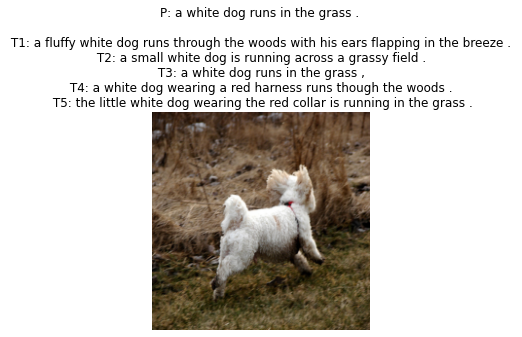

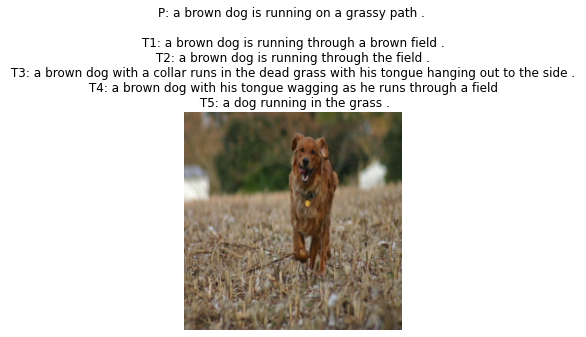

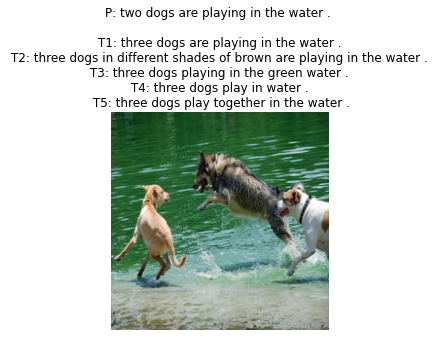

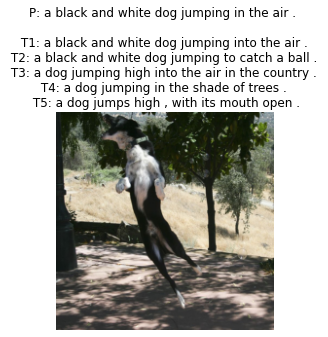

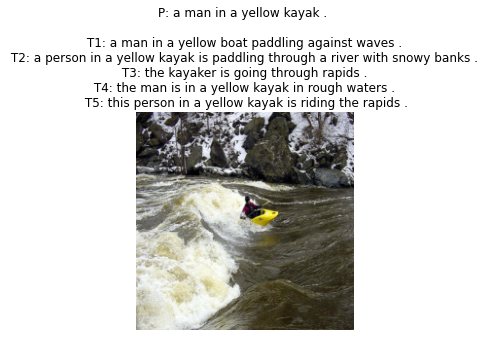

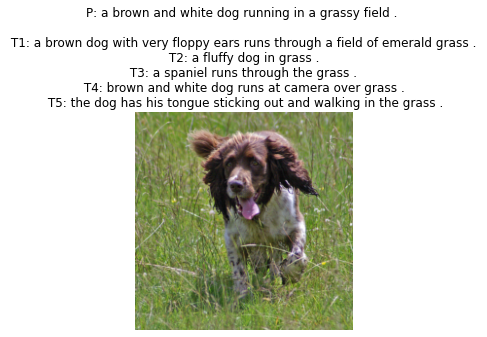

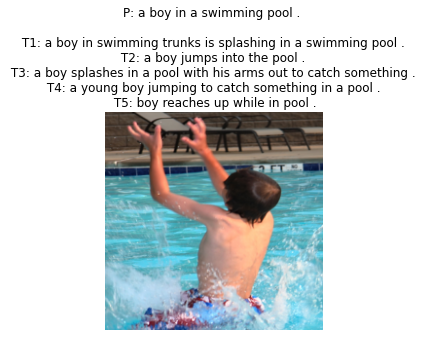

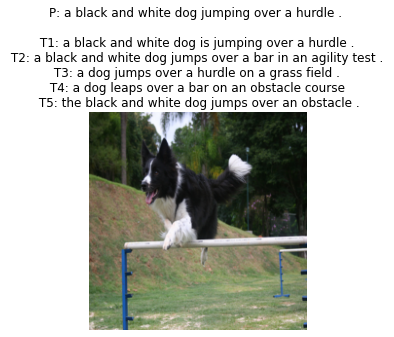

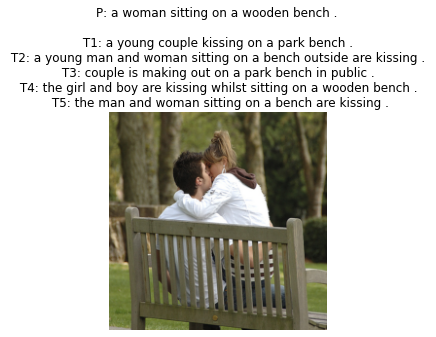

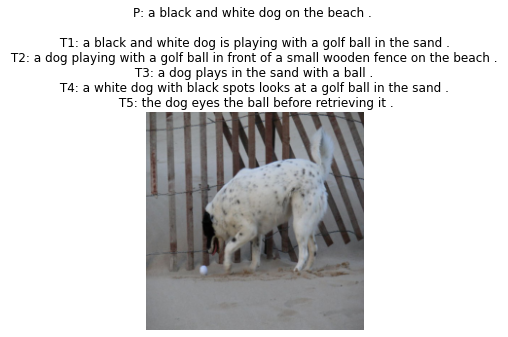

 
Images with bottom 10 BLEU score


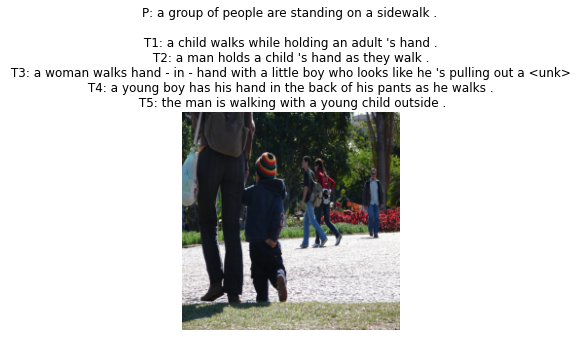

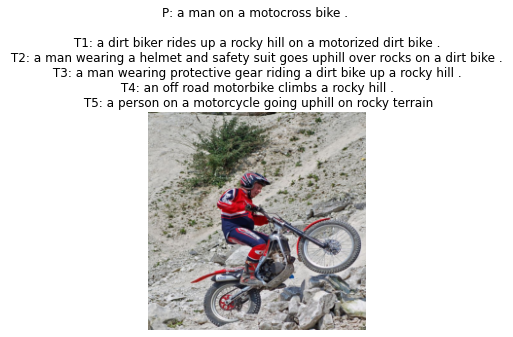

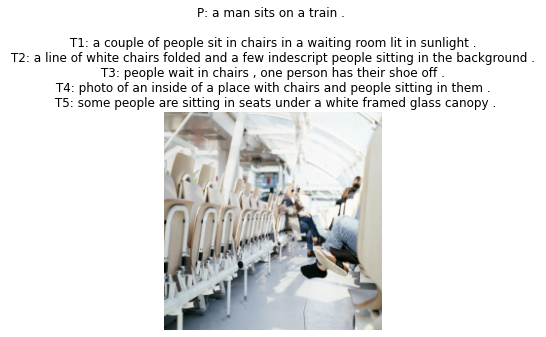

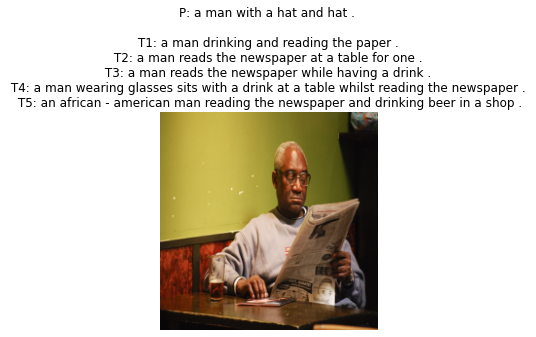

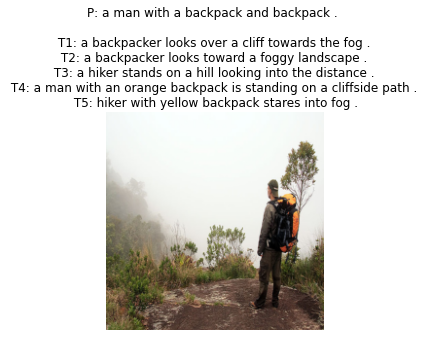

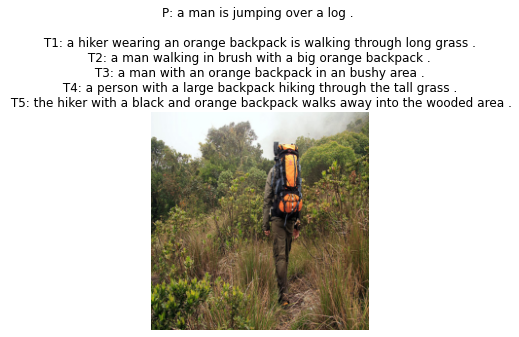

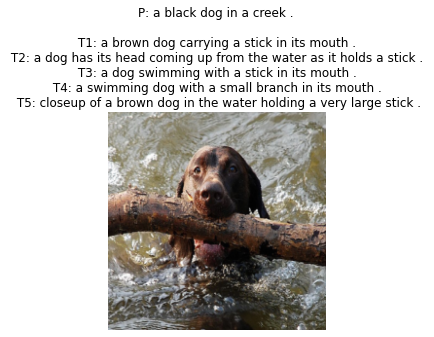

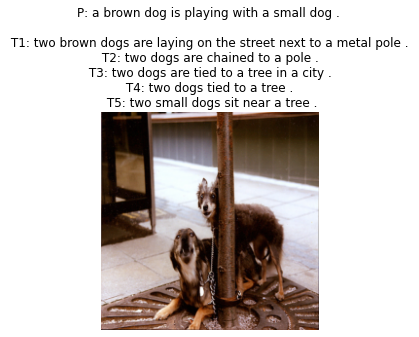

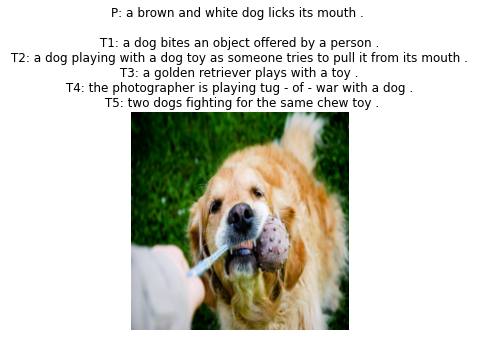

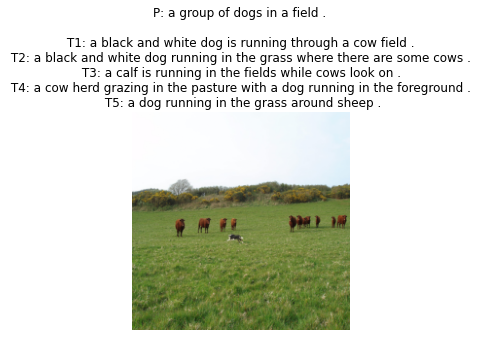

In [ ]:
# Visualise top 't' images and bottom 't' images (best and lowest scores)
t_ = 10

print('MODEL 1 (Flickr8k). BEAM SEARCH. k = 5')
print(' ')
print(f'Images with top {t_} BLEU score')
for i in range(t_): # top t
  img = images[inds[i]]
  img = torch.transpose(torch.transpose(img, 0, 1), 1, 2).cpu().data.numpy()
  truth, prediction = predict_new(model, test_loader, inds[i],  dataset_targets=testset, dataset_for_prediction=dataset, method='beam', k=3)
  Pr = list(filter(lambda x : x not in ['<pad>', '<eos>', '<sos>'], prediction))
  Pr = ' '.join(map(str, Pr))
  Tr1 = list(filter(lambda x : x not in ['<pad>', '<eos>', '<sos>'], truth[0]))
  Tr1 = ' '.join(map(str, Tr1))
  Tr2 = list(filter(lambda x : x not in ['<pad>', '<eos>', '<sos>'], truth[1]))
  Tr2 = ' '.join(map(str, Tr2))
  Tr3 = list(filter(lambda x : x not in ['<pad>', '<eos>', '<sos>'], truth[2]))
  Tr3 = ' '.join(map(str, Tr3))
  Tr4 = list(filter(lambda x : x not in ['<pad>', '<eos>', '<sos>'], truth[3]))
  Tr4 = ' '.join(map(str, Tr4))
  Tr5 = list(filter(lambda x : x not in ['<pad>', '<eos>', '<sos>'], truth[4]))
  Tr5 = ' '.join(map(str, Tr5))
  plt.imshow(img)
  plt.title(f'P: {Pr} \n \n T1: {Tr1} \n T2: {Tr2} \n T3: {Tr3} \n T4: {Tr4} \n T5: {Tr5}')
  plt.axis('off')
  plt.show()

print(' ')

print(f'Images with bottom {t_} BLEU score')
for i in range(len(inds)-1,len(inds)-1-t_,-1): # bottom t
  img = images[inds[i]]
  img = torch.transpose(torch.transpose(img, 0, 1), 1, 2).cpu().data.numpy()
  truth, prediction = predict_new(model, test_loader, inds[i],  dataset_targets=testset, dataset_for_prediction=dataset, method='beam', k=5)
  Pr = list(filter(lambda x : x not in ['<pad>', '<eos>', '<sos>'], prediction))
  Pr = ' '.join(map(str, Pr))
  Tr1 = list(filter(lambda x : x not in ['<pad>', '<eos>', '<sos>'], truth[0]))
  Tr1 = ' '.join(map(str, Tr1))
  Tr2 = list(filter(lambda x : x not in ['<pad>', '<eos>', '<sos>'], truth[1]))
  Tr2 = ' '.join(map(str, Tr2))
  Tr3 = list(filter(lambda x : x not in ['<pad>', '<eos>', '<sos>'], truth[2]))
  Tr3 = ' '.join(map(str, Tr3))
  Tr4 = list(filter(lambda x : x not in ['<pad>', '<eos>', '<sos>'], truth[3]))
  Tr4 = ' '.join(map(str, Tr4))
  Tr5 = list(filter(lambda x : x not in ['<pad>', '<eos>', '<sos>'], truth[4]))
  Tr5 = ' '.join(map(str, Tr5))
  plt.imshow(img)
  plt.title(f'P: {Pr} \n \n T1: {Tr1} \n T2: {Tr2} \n T3: {Tr3} \n T4: {Tr4} \n T5: {Tr5}')
  plt.axis('off')
  plt.show()


In [ ]:
print(f'Top 10 BLEU-4 scores are: {bleus[inds][:10]}')
print(f'Bottom 10 BLEU-4 scores are: {bleus[inds][-10:]}')

Top 10 BLEU-4 scores are: [100.    86.94  84.09  84.09  84.09  80.91  79.53  78.56  76.73  74.77]
Bottom 10 BLEU-4 scores are: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# MODEL WITH Flickr30k DATASET

## Load dataset and generate loaders

In [ ]:
!unzip '/content/drive/MyDrive/GroupProjectNLP/flickr30k.zip'

In [ ]:
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor()
])

# Training dataset & loader: will only give 1 target sentence per image
dataset = FlickrDataset(
    root='/content/flickr30k_images/flickr30k_images',
    ann_file='/content/drive/MyDrive/GroupProjectNLP/flickr30k_train.csv',
    img_transform=transform
)

train_loader = DataLoader(
    dataset=dataset,
    batch_size=100,
    num_workers=8,
    shuffle=False,
    pin_memory=True,
    collate_fn=collate_fn
)

# Validation: will give 5 sentences per image
valset = FlickrDatasetVal(
    root='/content/flickr30k_images/flickr30k_images',
    ann_file='/content/drive/MyDrive/GroupProjectNLP/flickr30k_val.csv',
    img_transform=transform
)

val_loader = DataLoader(
    dataset=valset,
    batch_size=100,
    num_workers=8,
    shuffle=False,
    collate_fn=collate_fn_val
)

# Testing
testset = FlickrDatasetVal(
    root='/content/flickr30k_images/flickr30k_images',
    ann_file='/content/drive/MyDrive/GroupProjectNLP/flickr30k_test.csv',
    img_transform=transform
)

test_loader = DataLoader(
    dataset=testset,
    batch_size=100,
    num_workers=8,
    shuffle=False,
    collate_fn=collate_fn_val)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Load best trained model (Model 4)

In [ ]:
vocab_size = len(dataset.vocab.stoi)
d_model = 128
img_feature_size = 1792
output_size = 128
dim_feedforward=512

model = Transformer(
    d_model=d_model, nhead=4, num_encoder_layers=3, num_decoder_layers=3, 
    pos_dropout=0.1, trans_dropout=0.1, dim_feedforward=dim_feedforward,
    img_features_size=img_feature_size, output_size=output_size,
    vocab_size = vocab_size).to(device)

opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<pad>"])

checkpoint = torch.load('/content/drive/MyDrive/GroupProjectNLP/trained_models/checkpoint10.pt')
model.load_state_dict(checkpoint['state_dict'])
model.eval()

## Validation for hyperparameter tuning
Use the validation set to find which hyperparameter $k$ of beam search gives the highest BLEU score. The best score with this model is obtained for $k = 5$.

In [ ]:
ks = [1,2,3,4,5]

for i in ks:
  beam_bleu_score_val = beam_validation_loop(model, val_loader, valset, k=i)
  print(f"Beam Search BLEU-4 score on validation set for k = {i}: {beam_bleu_score_val}")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Beam Search BLEU-4 score on validation set for k = 1: 16.916999999999998
Beam Search BLEU-4 score on validation set for k = 2: 18.132
Beam Search BLEU-4 score on validation set for k = 3: 18.875999999999998
Beam Search BLEU-4 score on validation set for k = 4: 18.830000000000002
Beam Search BLEU-4 score on validation set for k = 5: 19.003999999999998


Now we calculate the n-gram BLEU scores for $n = 1,2,3,4$ on the test set with the best hyperparameter found for beam search $(k=5)$:

In [ ]:
best_k = 5
ns = [1,2,3,4]

for i in ns:
  beam_bleu_score_test = beam_validation_loop(model, test_loader, testset, k=best_k, bleu_n=i)
  print(f"BEAM BLEU-{i} (n = {i}) score on test set for k = {best_k}: {beam_bleu_score_test}")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


BEAM BLEU-1 (n = 1) score on test set for k = 5: 59.90899999999999
BEAM BLEU-2 (n = 2) score on test set for k = 5: 39.36
BEAM BLEU-3 (n = 3) score on test set for k = 5: 26.095
BEAM BLEU-4 (n = 4) score on test set for k = 5: 17.35


# VISUALISE RESULTS FOR MODEL 4 (Flickr30k)
Use BLEU-4 and $k = 5$ for Beam Search.

## Set test loader batch size to 1
This is just to be able to compute the BLEU score for every single image and rank the images from best score to worst.


In [ ]:
test_loader = DataLoader(
    dataset=testset,
    batch_size=1,
    num_workers=8,
    shuffle=False,
    collate_fn=collate_fn_val
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Get BLEU-4 score for every image in the test set and sort them in descending order

In [ ]:
bleus, images = get_bleu_beam_testing(model, test_loader, testset, k=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Sort 'images' in terms of descending 'bleus'.
bleus = np.array(bleus)
inds = (-bleus).argsort()

## Visualiase top 10 and bottom 10 predicted images in the test set

In [ ]:
# Visualise top 't' images and bottom 't' images (best and lowest scores)
t_ = 10

print('MODEL 4 (Flickr30k). BEAM SEARCH. k = 5')
print(' ')
print(f'Images with top {t_} BLEU score')
for i in range(t_): # top t
  img = images[inds[i]]
  img = torch.transpose(torch.transpose(img, 0, 1), 1, 2).cpu().data.numpy()
  truth, prediction = predict_new(model, test_loader, inds[i],  dataset_targets=testset, dataset_for_prediction=dataset, method='beam', k=3)
  Pr = list(filter(lambda x : x not in ['<pad>', '<eos>', '<sos>'], prediction))
  Pr = ' '.join(map(str, Pr))
  Tr1 = list(filter(lambda x : x not in ['<pad>', '<eos>', '<sos>'], truth[0]))
  Tr1 = ' '.join(map(str, Tr1))
  Tr2 = list(filter(lambda x : x not in ['<pad>', '<eos>', '<sos>'], truth[1]))
  Tr2 = ' '.join(map(str, Tr2))
  Tr3 = list(filter(lambda x : x not in ['<pad>', '<eos>', '<sos>'], truth[2]))
  Tr3 = ' '.join(map(str, Tr3))
  Tr4 = list(filter(lambda x : x not in ['<pad>', '<eos>', '<sos>'], truth[3]))
  Tr4 = ' '.join(map(str, Tr4))
  Tr5 = list(filter(lambda x : x not in ['<pad>', '<eos>', '<sos>'], truth[4]))
  Tr5 = ' '.join(map(str, Tr5))
  plt.imshow(img)
  plt.title(f'P: {Pr} \n \n T1: {Tr1} \n T2: {Tr2} \n T3: {Tr3} \n T4: {Tr4} \n T5: {Tr5}')
  plt.axis('off')
  plt.show()

print(' ')

print(f'Images with bottom {t_} BLEU score')
for i in range(len(inds)-1,len(inds)-1-t_,-1): # bottom t
  img = images[inds[i]]
  img = torch.transpose(torch.transpose(img, 0, 1), 1, 2).cpu().data.numpy()
  truth, prediction = predict_new(model, test_loader, inds[i],  dataset_targets=testset, dataset_for_prediction=dataset, method='beam', k=5)
  Pr = list(filter(lambda x : x not in ['<pad>', '<eos>', '<sos>'], prediction))
  Pr = ' '.join(map(str, Pr))
  Tr1 = list(filter(lambda x : x not in ['<pad>', '<eos>', '<sos>'], truth[0]))
  Tr1 = ' '.join(map(str, Tr1))
  Tr2 = list(filter(lambda x : x not in ['<pad>', '<eos>', '<sos>'], truth[1]))
  Tr2 = ' '.join(map(str, Tr2))
  Tr3 = list(filter(lambda x : x not in ['<pad>', '<eos>', '<sos>'], truth[2]))
  Tr3 = ' '.join(map(str, Tr3))
  Tr4 = list(filter(lambda x : x not in ['<pad>', '<eos>', '<sos>'], truth[3]))
  Tr4 = ' '.join(map(str, Tr4))
  Tr5 = list(filter(lambda x : x not in ['<pad>', '<eos>', '<sos>'], truth[4]))
  Tr5 = ' '.join(map(str, Tr5))
  plt.imshow(img)
  plt.title(f'P: {Pr} \n \n T1: {Tr1} \n T2: {Tr2} \n T3: {Tr3} \n T4: {Tr4} \n T5: {Tr5}')
  plt.axis('off')
  plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(f'Top 10 BLEU-4 scores are: {bleus[inds][:10]}')
print(f'Bottom 10 BLEU-4 scores are: {bleus[inds][-10:]}')

Top 10 BLEU-4 scores are: [100.    86.94  84.09  79.53  78.97  77.44  74.77  73.98  73.11  70.81]
Bottom 10 BLEU-4 scores are: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
